In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [9]:
x = np.loadtxt("d:/datasets/uci/madelon/madelon_train.data")
y = np.loadtxt("d:/datasets/uci/madelon/madelon_train.labels", delimiter=',')
xt = np.loadtxt("d:/datasets/uci/madelon/madelon_valid.data")
yt = np.loadtxt("d:/datasets/uci/madelon/madelon_valid.labels", delimiter=',')
print(x.shape,y.shape,xt.shape,yt.shape)

(2000, 500) (2000,) (600, 500) (600,)


In [2]:
x = np.loadtxt("d:/datasets/uci/dexter/dexter_train.csv", delimiter=',')
y = np.loadtxt("d:/datasets/uci/dexter/dexter_train.labels", delimiter=',')
xt = np.loadtxt("d:/datasets/uci/dexter/dexter_valid.csv", delimiter=',')
yt = np.loadtxt("d:/datasets/uci/dexter/dexter_valid.labels", delimiter=',')
print(x.shape,y.shape,xt.shape,yt.shape)

(300, 20000) (300,) (300, 20000) (300,)


In [50]:
x = np.loadtxt("d:/datasets/uci/hill-valley/x.dat")
y = np.loadtxt("d:/datasets/uci/hill-valley/y.dat", delimiter=',')
xt = np.loadtxt("d:/datasets/uci/hill-valley/xtest.dat")
yt = np.loadtxt("d:/datasets/uci/hill-valley/ytest.dat", delimiter=',')
print(x.shape,y.shape,xt.shape,yt.shape)

(606, 100) (606,) (606, 100) (606,)


In [16]:
x = np.loadtxt("d:/datasets/uci/gisette/gisette_train.data")
y = np.loadtxt("d:/datasets/uci/gisette/gisette_train.labels", delimiter=',')
xt = np.loadtxt("d:/datasets/uci/gisette/gisette_valid.data")
yt = np.loadtxt("d:/datasets/uci/gisette/gisette_valid.labels", delimiter=',')
print(x.shape,y.shape,xt.shape,yt.shape)

(6000, 5000) (6000,) (1000, 5000) (1000,)


In [17]:
sx=np.std(x,axis=0)
x=x[:,sx>0]
xt=xt[:,sx>0]
mx=np.mean(x,axis=0)
sx=np.std(x,axis=0)
print(x.shape)
x=torch.tensor((x-mx)/sx).float()
xt=torch.tensor((xt-mx)/sx).float()
y=torch.tensor(y).float()
yt=torch.tensor(yt).float()
print(torch.std(x,axis=0))

(6000, 4955)
tensor([1.0001, 1.0001, 1.0001,  ..., 1.0001, 1.0001, 1.0001])


In [18]:
n=x.shape[0]
nt=xt.shape[0]
y1=y.clone()
yt1=yt.clone()

In [19]:
y[y<0]=0
yt[yt<0]=0

In [20]:
x.shape

torch.Size([6000, 4955])

In [32]:
def loss(h,y):
    yh=y.reshape(-1,1)*h
    leyh=torch.log(1+torch.exp(-yh))
    return torch.sum(leyh,dim=0)

def err(xw,y):
    py=(xw>0).float()
    return torch.mean((py!=y).float()).item()

def regress(x,y,w):
    yb=torch.sum(y.view(-1)*w.view(-1))/torch.sum(w)
    xb=torch.sum(x*w.view(-1,1),dim=0)/torch.sum(w)
    xm=x-xb.view(1,-1)
    wym=w.view(-1)*(y.view(-1)-yb)
    num=wym.view(1,-1)@xm
    den=w.view(1,-1)@(xm**2)
    b1=(num/den).view(-1)
    b0=yb-b1*xb
    #print(b1.shape,b0.shape)
    return b0,b1

h=torch.zeros(n)

p=1/(1+torch.exp(-h))
w=p*(1-p)
z=1/p
z[y==0]=-1/(1-p[y==0])
b0,b1=regress(x,z,w)
wh=b0.view(1,-1)+b1.view(1,-1)*x
newh=h.view(-1,1)+wh
l=loss(newh,y1)
print(l)

tensor([4158.8560, 4158.8413, 4037.3716,  ..., 4127.8784, 4158.8833,
        4027.8503])


10 499 0.6495817303657532 10 10


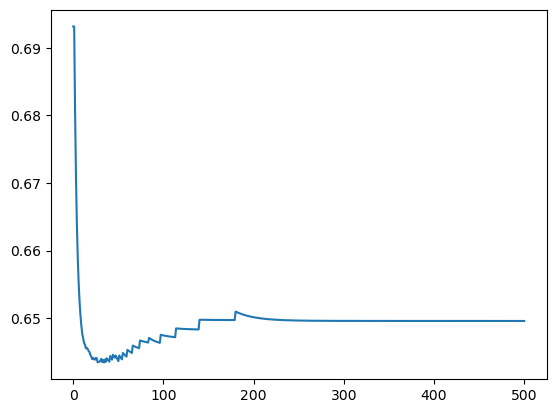

30 499 0.6277459263801575 30 30


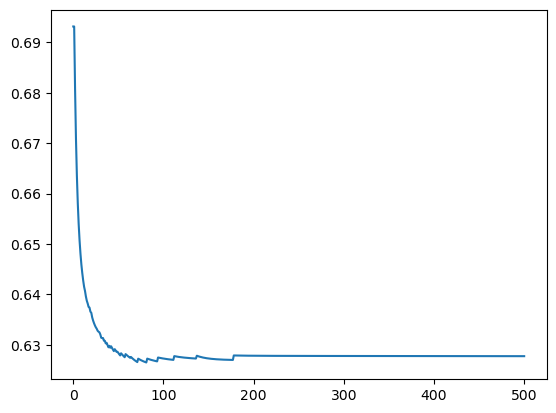

100 499 0.5821059942245483 100 100


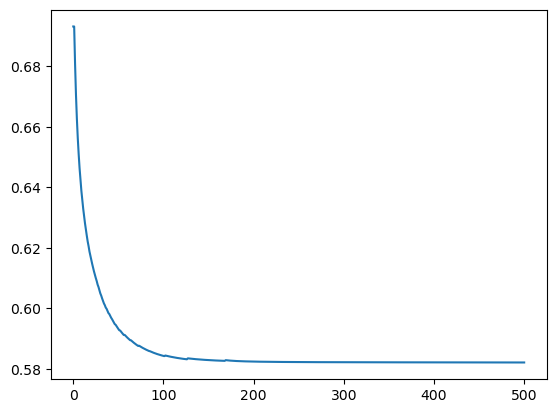

300 499 0.5362658500671387 300 300


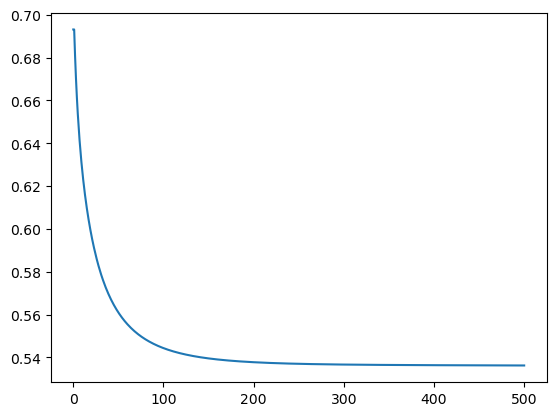

500 499 0.520077109336853 500 500


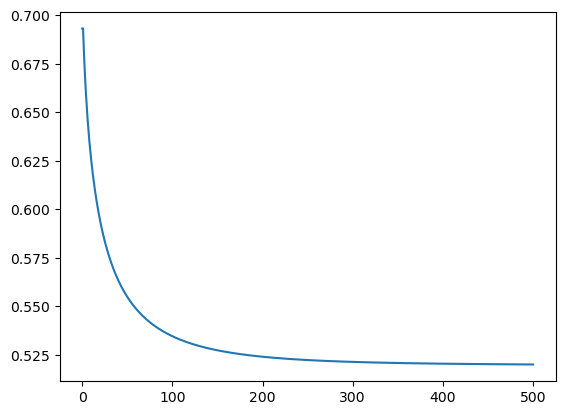

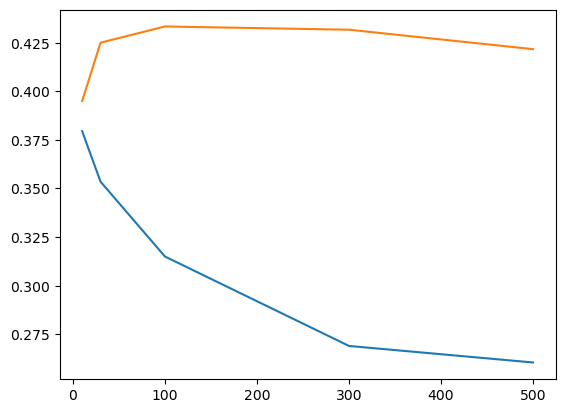

In [14]:
def loss(xw,y,w,s):
    yxw=y.reshape(-1)*xw.reshape(-1)
    leyxw=torch.log(1+torch.exp(-yxw))
    return torch.mean(leyxw)+s*torch.sum(w**2)

def grad(x,w,y,s):
    xw=x@w
    yxw=y.reshape(-1)*xw.reshape(-1)
    eyxw=torch.exp(-yxw)
    a=-y.reshape(-1)*eyxw/(1+eyxw)
    g=x.T@a
    return g/x.shape[0]+2*s*w

def err(xw,y):
    py=(xw>0).float()
    return torch.mean((py!=y).float()).item()

eta=.1
s=0.0001
Nit=500
mu=200
ks=[10,30,100,300,500]
#ks=[10]
p=x.shape[1]
ferrs=[]
ferrst=[]
for k in ks:
    w=torch.zeros((p))
    #w.requires_grad=True
    xw=x@w
    l=loss(xw,y1,w,s)
    #print(xw.shape,y.shape,l)
    los=[l.item()]
    errs=[err(xw,y)]
    xtw=xt@w
    errst=[err(xtw,yt)]
    idx = np.arange(p)
    #optimizer = torch.optim.SGD([w], lr=eta)
    for it in range(Nit):
    #    optimizer.zero_grad()
        xw=x[:,idx]@w
        g=grad(x[:,idx],w,y1,s)
        w=w-eta*g # gradient update
        l=loss(xw,y1,w,s)
   #     l.backward()
   #     optimizer.step()
        los.append(l.item())
        m=int(k+(p-k)*max(0,(Nit-2*it)/(2*it*mu+Nit)))
        if (m<w.shape[0]):
            sw=torch.sort(torch.abs(w),descending=True)[0]
            thr=sw[m-1]
            idx=idx[torch.abs(w)>=thr]
            w=w[torch.abs(w)>=thr]
    print(k,it,l.item(),m,torch.sum(w!=0).item())
    xtw=xt[:,idx]@w
    e=err(xw,y)
    et=err(xtw,yt)
    ferrs.append(e)
    ferrst.append(et)
    plt.plot(los)
    plt.show()
plt.plot(ks,ferrs)
plt.plot(ks,ferrst)
plt.show()

In [15]:
print(ferrs)
print(ferrst)

[0.37950000166893005, 0.35350000858306885, 0.3149999976158142, 0.26899999380111694, 0.2605000138282776]
[0.39500001072883606, 0.42500001192092896, 0.4333333373069763, 0.43166667222976685, 0.4216666519641876]


In [113]:
xwt=xt@w
print(err(xw,y),err(xwt,yt))

0.3255 0.42833333333333334


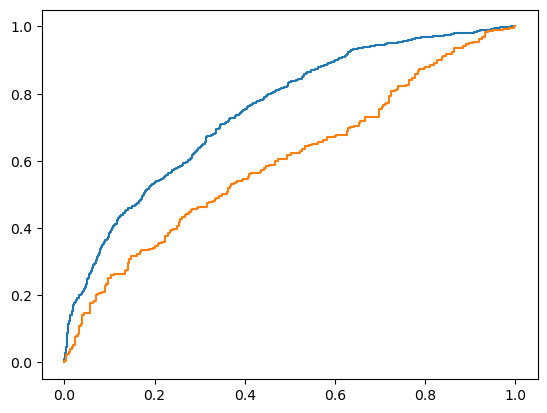

In [114]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, xw)
fprt, tprt, thresholds = metrics.roc_curve(yt, xwt)
plt.plot(fpr,tpr)
plt.plot(fprt,tprt)